<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio NLP + Sist. Recomendación


En este laboratorio, tabrajaras con datos de reseñas de productos para construir un sistema de recomendación que utilice procesamiento de lenguaje natural (NLP) y *machine learning*. El objetivo principal es que analices el contenido textual de las reseñas, clasifiques las opiniones en categorías (positiva, negativa o neutra) y aproveches esta información para personalizar las recomendaciones. El sistema priorizará los productos con mejores reseñas para usuarios específicos y permitirá evaluar si el análisis de sentimientos mejora la calidad de las recomendaciones. Tareas propuestas:


**Caso 1: Crear un sistema de recomendación**: Debes generar un sistema de recomendación para priorizar productos con las reseñas para cada usuario. Los pasos que deberás seguir son:    

- Estructurar el conjunto de datos

- Sistema basado en contenido


**Caso 2: Clasificar reseñas en positivas, negativas o neutras** Deberás implementar un modelo para analizar las reseñas textuales y clasificarlas en tres categorías:

- Positivas: Si el sentimiento de la reseña es favorable.

- Negativas: Si el sentimiento de la reseña es desfavorable.

- Neutras: Si la reseña no tiene un sentimiento claro.
	
- Pasos :
	- Preprocesamiento de texto: Limpiar las reseñas eliminando caracteres especiales, palabras vacías (stopwords) y realizar lematización.
	
	- Identificar las reseñas positivas, negativas y neutrales. 


Los datos los tendréis en el [siguiente enlace](https://drive.google.com/drive/u/0/folders/1vK5zESy9KElRhm_utg_lHHXuUArrwWgu) con la descipción de cada una de las columnas.  

____________________________________

### **1. Sistema de recomendación basado en contenido**

In [101]:
%load_ext autoreload
%autoreload 2
# -----------------------------------------------------------------------
import pandas as pd
import math
import re


# Visualizaciones
# -----------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Para modelos NLP
# -----------------------------------------------------------------------
import spacy
from nltk.corpus import stopwords
import nltk
import contractions
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity



from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix


# Configuración de pandas
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None)


# Otros
# -----------------------------------------------------------------------
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("/")
from src import soporte_nlp as sn
from src import soporte_sistemas_recomendacion as ss
from src import funciones_eda as fe

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
df = pd.read_csv("datos/datos.csv", index_col=[0])
df.head(2)

,reviewId,reviewDate,mainDepartment,subDepartment,productName,reviewTitle,reviewStar,reviewText,inconsistentStatus
65115,RXDM4W1ZL7L4L,"Reviewed in the United States on June 22, 2021",Sports and Outdoors,Outdoor Recreation,Doctor Developed Copper Wrist Brace / Carpal T...,One size does not fit all.,3.0,Nice lightweight brace but unfortunately was t...,1
56720,R2GINAKQJOSWEL,"Reviewed in the United States on August 27, 2021",Computers,Men's Clothing,Fruit of the Loom Men's Coolzone Boxer Briefs,They were ok but thats it,4.0,Boxers were ok. The color did start to fade pr...,0


In [82]:
df.shape

(10000, 9)

Comprobamos si hay nulos en las columnas de productName y reviewText, de haberlos las eliminamos:

In [83]:
df.isna().sum()

reviewId              0
reviewDate            0
mainDepartment        0
subDepartment         0
productName           0
reviewTitle           5
reviewStar            0
reviewText            1
inconsistentStatus    0
dtype: int64

In [84]:
df.dropna(subset=["reviewText"], inplace=True)

Comprobamos si hay productos duplicados:

In [85]:
df["productName"].duplicated().sum()

np.int64(9900)

Nos quedamos con las columnas que nos interesan que son `productName`, a través de la cual vamos a hacer un group by, y `reviewText` las cuales vamos a agrupas en base al productName.

In [86]:
# df_simple = df[["productName", "reviewText"]]
# df_grouped = df_simple.groupby("productName").sum().reset_index()

In [87]:
df_grouped = df.groupby("productName").agg(
    reviewStar_median=("reviewStar", "median"),  # Calcular la media de 'reviewStar'
    reviewText=("reviewText", lambda texts: " ".join(texts))  # Unir textos de reviews
).reset_index()

df_grouped.head()

,productName,reviewStar_median,reviewText
0,"(Refurbished) Apple iPhone 7, 32GB, Black - Fu...",3.0,I’ll admit I was very skeptical from reviews b...
1,AIMEILI Gel Nail Polish No Wipe Top and Base C...,3.0,"It’s thick, but works good once you get used t..."
2,AKASO EK7000 4K30FPS Action Camera Ultra HD Un...,3.0,I was not impressed with the image quality. A...
3,"ASUS Laptop L210 Ultra Thin Laptop, 11.6” HD D...",3.0,The laptop arrived just in time for school!! W...
4,"Acer Aspire 5 A515-46-R14K Slim Laptop | 15.6""...",3.0,Bought for school work. Doing good so far.Slee...


Vamos a limpiar la columna de `reviewText` antes de vectorizarla:

In [88]:
exploracion = sn.ExploracionText(df_grouped, "reviewText", "productName")

In [89]:
df_res = exploracion.limpiar_textos("reviewText_limpia")
df_limpio = df_res[["productName", "reviewText_limpia", "reviewStar_median"]].reset_index(drop=True)
print(df_limpio.shape)
df_limpio.head()

Limpiando el texto...
Texto limpiado y listo.
(99, 3)


,productName,reviewText_limpia,reviewStar_median
0,"(Refurbished) Apple iPhone 7, 32GB, Black - Fu...",admit skeptical review decide purchase anyway ...,3.0
1,AIMEILI Gel Nail Polish No Wipe Top and Base C...,thick work good get use base top coat work gre...,3.0
2,AKASO EK7000 4K30FPS Action Camera Ultra HD Un...,impressed image quality also app suggest use p...,3.0
3,"ASUS Laptop L210 Ultra Thin Laptop, 11.6” HD D...",laptop arrive time school work great product d...,3.0
4,"Acer Aspire 5 A515-46-R14K Slim Laptop | 15.6""...",buy school work good farsleek alright buy lapt...,3.0


Realizamos la vectorización, es decir, convertimos el texto a vectores y así poder calcular las distancias entre distintos productos.


In [22]:
repre = sn.RepresentacionTexto(df_limpio, "reviewText_limpia")
similarity = repre.distancias_labels("productName")

Ahora ya podremos realizar una recomendación de productos parecidos en base a uno dado:

Ejemplo: Coleman Cooler Quad Portable Camping Chair, Blue

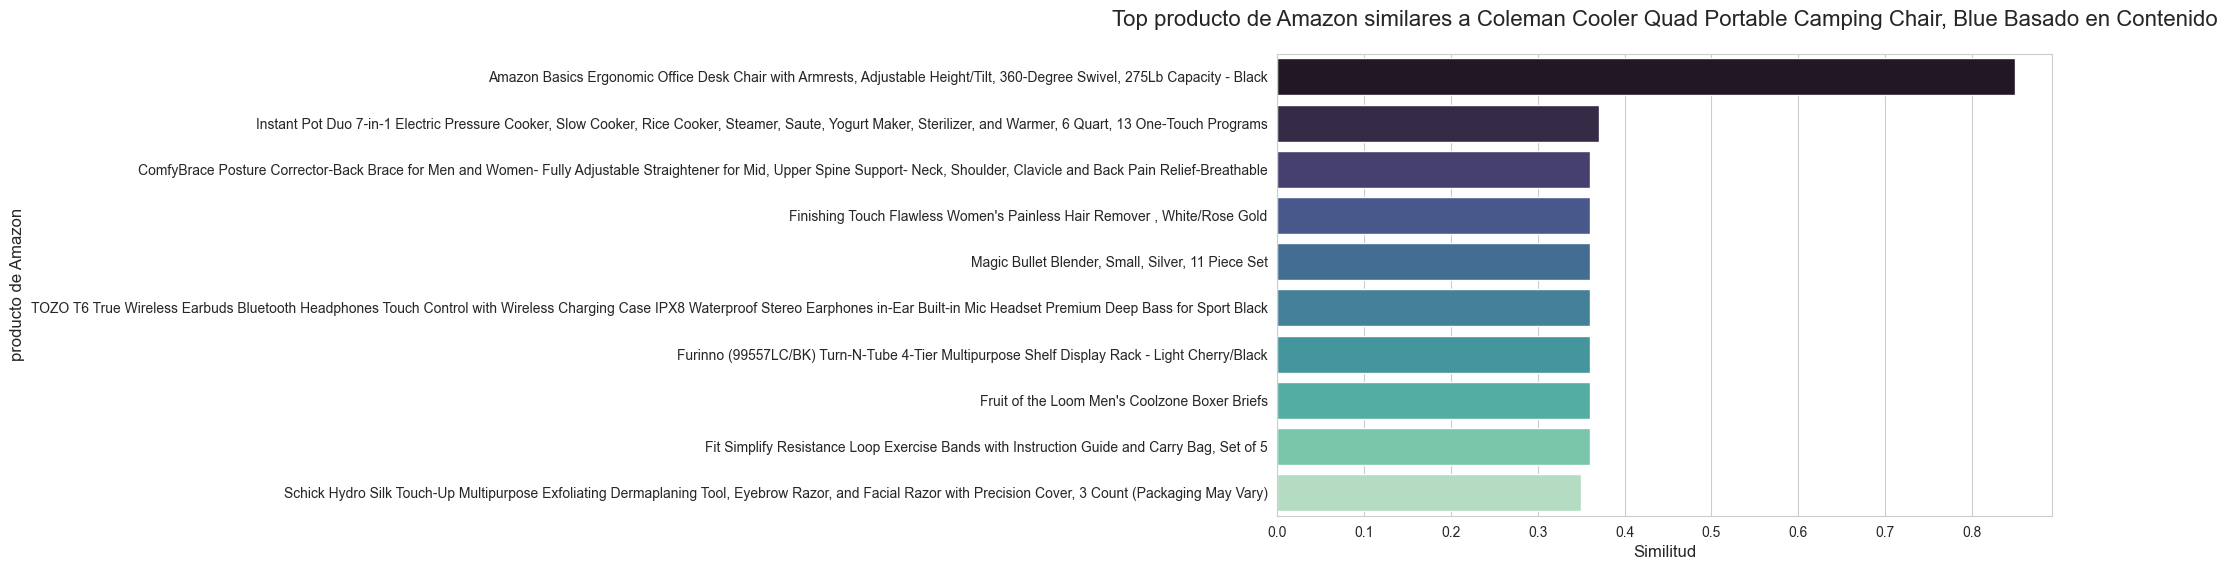

In [23]:
ss.recomendaciones_contenido(similarity, df_limpio, "productName")

In [90]:
df_limpio_2 = df_limpio.copy()

___________________________________________________________________________________________

### **Caso 2: Clasificar reseñas en positivas, negativas o neutras** 

In [126]:
df = pd.read_csv("datos/datos.csv", index_col=[0])
df.dropna(subset=["reviewText"], inplace=True)
df_caso2 = df[["productName", "reviewText", "reviewStar"]]
df_caso2.head(3)

,productName,reviewText,reviewStar
65115,Doctor Developed Copper Wrist Brace / Carpal T...,Nice lightweight brace but unfortunately was t...,3.0
56720,Fruit of the Loom Men's Coolzone Boxer Briefs,Boxers were ok. The color did start to fade pr...,4.0
26571,"TP-Link AC750 WiFi Extender (RE220), Covers Up...",Very easy to install. Worked right away but it...,4.0


Lo primero es limpiar la columna de la review para pasarla a minúsculas, eliminar caractéres especiales, etc.

In [127]:
exploracion = sn.ExploracionText(df_caso2, "reviewText", "productName")
df_res = exploracion.limpiar_textos("reviewText_limpia")
df_limpio = df_res.drop(columns=["reviewText"])
df_limpio.head()


Limpiando el texto...
Texto limpiado y listo.


,productName,reviewStar,reviewText_limpia
65115,Doctor Developed Copper Wrist Brace / Carpal T...,3.0,nice lightweight brace unfortunately large wri...
56720,Fruit of the Loom Men's Coolzone Boxer Briefs,4.0,boxer ok color start fade pretty quickly becom...
26571,"TP-Link AC750 WiFi Extender (RE220), Covers Up...",4.0,easy install work right away go far expectedit...
40292,"Gorilla Grip Luxury Chenille Bathroom Rug Mat,...",1.0,color completely different hunter green andor ...
5884,WOW Apple Cider Vinegar Shampoo and Hair Condi...,2.0,read review hope shampoo conditioner would ext...


Realizamos el análisis de sentimientos para cada producto:

In [128]:
df_limpio["sentimientos"] = df_limpio["reviewText_limpia"].apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x))
columnas = df_limpio["sentimientos"].apply(pd.Series).columns
df_limpio[columnas] = df_limpio["sentimientos"].apply(pd.Series)

df_limpio.drop(columns=["sentimientos"], inplace=True)
df_limpio.head(1)

,productName,reviewStar,reviewText_limpia,neg,neu,pos,compound
65115,Doctor Developed Copper Wrist Brace / Carpal T...,3.0,nice lightweight brace unfortunately large wri...,0.121,0.603,0.276,0.4767


Agrupamos las filas cuyo product name es el mismo:

In [131]:
df_grouped = df_limpio.groupby("productName").agg(
    reviewStar=("reviewStar", "median"), 
    reviewText=("reviewText_limpia", lambda texts: " ".join(texts)),
    neg=("neg", "median"), 
    neu=("neu", "median"), 
    pos=("pos", "median"),
    compound=("compound", "median")

).reset_index()

df_grouped.head()

,productName,reviewStar,reviewText,neg,neu,pos,compound
0,"(Refurbished) Apple iPhone 7, 32GB, Black - Fu...",3.0,admit skeptical review decide purchase anyway ...,0.000,0.6670,0.219,0.2960
1,AIMEILI Gel Nail Polish No Wipe Top and Base C...,3.0,thick work good get use base top coat work gre...,0.000,0.5800,0.326,0.5859
2,AKASO EK7000 4K30FPS Action Camera Ultra HD Un...,3.0,impressed image quality also app suggest use p...,0.000,0.6295,0.260,0.6059
3,"ASUS Laptop L210 Ultra Thin Laptop, 11.6” HD D...",3.0,laptop arrive time school work great product d...,0.017,0.6450,0.194,0.2263
4,"Acer Aspire 5 A515-46-R14K Slim Laptop | 15.6""...",3.0,buy school work good farsleek alright buy lapt...,0.000,0.6610,0.196,0.3612


Observemos si a mejor valoriación se obtiene una vloriación positiva mayor o menor en los comentarios:

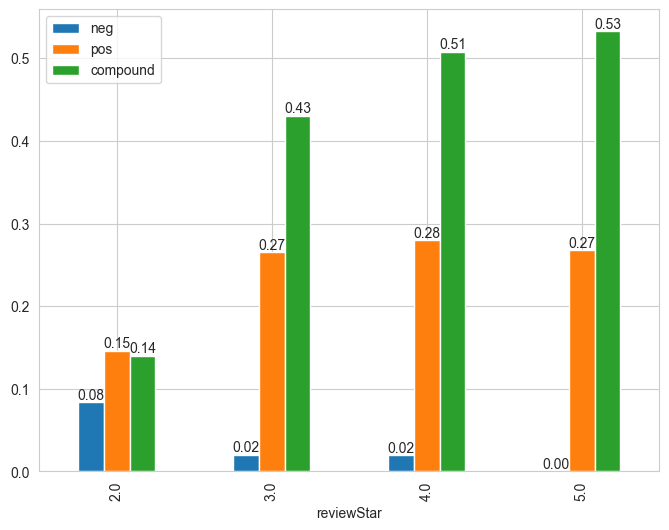

In [137]:
df_stars = df_grouped[['reviewStar', 'neg', 'pos', 'compound']].groupby("reviewStar").mean()
ax = df_stars.plot(kind="bar", figsize=(8, 6), legend=True)
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f")

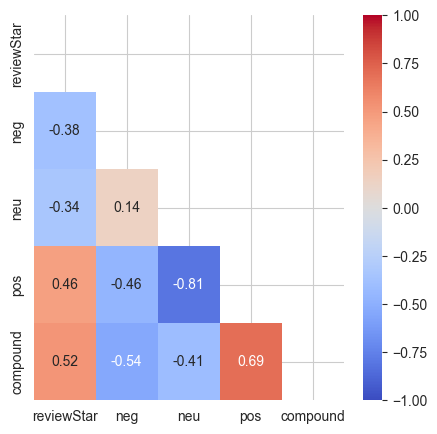

In [139]:
fe.heatmap_correlacion(df_grouped, figsize=(5,5))

Efectivamente, cuantas más estrellas se le dan al producto de mediana obtiene puntuaciones más altas en cuanto a sentimientos positivos en los comentarios de dicho producto.

_____________________________________